In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist

In [2]:
def backtracking(x, f, df, d, alpha0=1., c=1e-3, r=0.9, maxI=100):
    alpha = alpha0
    counter = 0
    fin = 0
    
    while not fin:
        if (f(x - alpha*d) <= f(x) - c*alpha*df(x)@d):
            fin = 1
        if (counter >= maxI): fin = 1
        alpha = r*alpha
        counter = counter + 1
        
    return alpha, counter

In [3]:
def lineSearch(x0, f, df, alpha0=1., maxI=1000, eps=1e-3, crit='abserrorx', c=1e-3, r=0.9):
    iters = 0
    fin = 0
    convergence = 0
    x = x0.copy()
    n = x.shape[0]    

    xk = []
    fk = []
    dfk = []
    errk = []
    bk = [0]
    xk.append(x)
    fk.append(f(x))
    dfk.append(df(x))
    errk.append(np.linalg.norm(xk, 1))
    
    while not fin:
        oldx = x
        gr = df(x)
        alpha, ct = backtracking(x, f, df, gr, alpha0, c, r)
        x = oldx - alpha*gr
        fx = f(x)
        dfx = df(x)
        iters += 1
        xk.append(x)
        fk.append(fx)
        dfk.append(dfx)
        bk.append(ct)
        
        if (crit == 'abserrorx'):
            error = np.linalg.norm(oldx-x)
        elif (crit == 'relerrorx'):
            error = np.linalg.norm(oldx-x)/np.linalg.norm(x)
        elif (crit == 'relerrorf'):
            error = np.abs(f(oldx)-fx)/np.abs(fx)
        elif (crit == 'normdf'):
            error = np.linalg.norm(dfx)
        else:
            error = -1.
            fin = 1
        if (error < eps):
            fin = 1
            convergence = 1
        errk.append(error)      
        if(iters >= maxI): fin = 1

    best = x
    xk = np.array(xk)
    fk = np.array(fk)
    dfk  = np.array(dfk)
    errk = np.array(errk)
    return [best, xk, fk, dfk, errk, bk, convergence, iters]

## Load Data

In [4]:
(trainX, trainY), (testX, testY) = mnist.load_data()

In [5]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


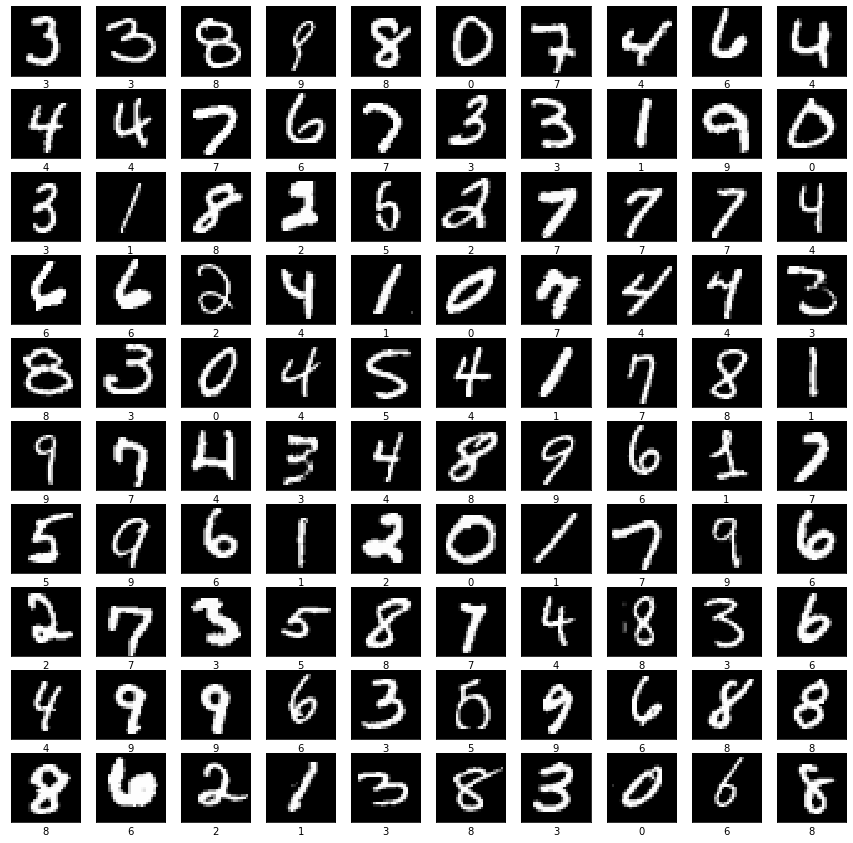

In [6]:
idx = np.random.choice(60000, size=100)
plt.figure(figsize=(15,15))
for i in range(0, 10):
    for j in range(0, 10):
        plt.subplot(10,10,10*i+j+1)
        plt.imshow(trainX[idx[10*i+j]], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(trainY[idx[10*i+j]])
plt.show()

In [7]:
itr = np.argwhere((trainY == 0) | (trainY == 1)).ravel()
its = np.argwhere((testY == 0) | (testY == 1)).ravel()

In [8]:
# select 0 and 1 images only
Xtr = trainX.reshape(60000,-1)[itr]
Xts = testX.reshape(10000,-1)[its]

# select 0 and 1 labels only
ytr = trainY[itr]
yts = testY[its]

# rescale X to [0,1]
Xtr = Xtr/Xtr.max()
Xts = Xts/Xts.max()

# convert y to float
ytr = ytr.astype(np.float32)
yts = yts.astype(np.float32)

In [9]:
print(Xtr.shape, ytr.shape, Xts.shape, yts.shape)

(12665, 784) (12665,) (2115, 784) (2115,)


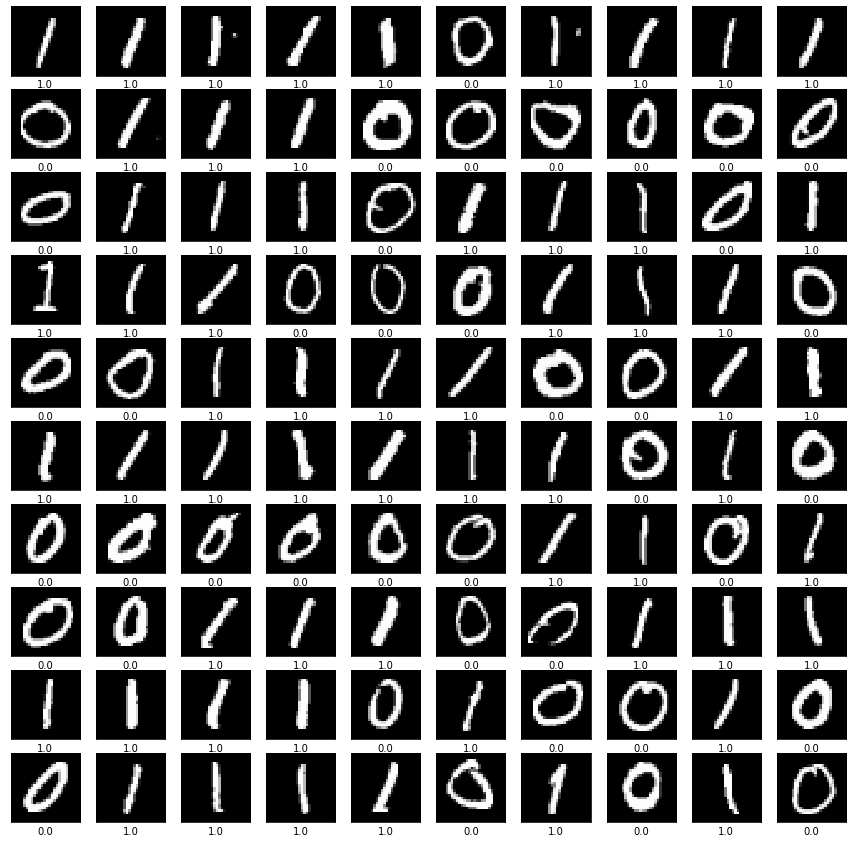

In [10]:
idx = np.random.choice(10000, size=100)
plt.figure(figsize=(15,15))
for i in range(0, 10):
    for j in range(0, 10):
        plt.subplot(10,10,10*i+j+1)
        plt.imshow(Xtr[idx[10*i+j]].reshape(28,28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(ytr[idx[10*i+j]])
plt.show()

In [11]:
Xtr = np.vstack([np.ones(Xtr.shape[0]), Xtr.T]).T
Xts = np.vstack([np.ones(Xts.shape[0]), Xts.T]).T

In [12]:
print(Xtr.shape, ytr.shape, Xts.shape, yts.shape)

(12665, 785) (12665,) (2115, 785) (2115,)


In [13]:
n = Xtr.shape[0]
n

12665

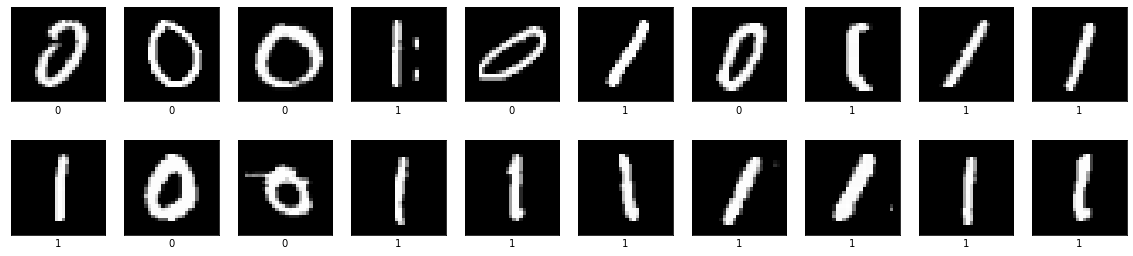

In [14]:
rows = 2
cols = 10
np.random.seed(2021)
idx = np.random.permutation(n)[:rows*cols]

plt.figure(figsize=(20,4.5))
for i in range(0, rows):
    for j in range(0, cols):
        plt.subplot(rows,cols,cols*i+j+1)
        plt.imshow(Xtr[idx[cols*i+j]][1:].reshape(28,28), cmap='gray')
        plt.xlabel(int(ytr[idx[cols*i+j]]))
        plt.xticks([])
        plt.yticks([])
plt.show()

## Sigmoid function

In [16]:
def ker(X):
    f = 1. / (1. + np.exp(-x@b))
    return f

def ds(x, b):
    pi = s(x,b)
    df = -pi*(1.-pi)*x
    return df

In [17]:
def ss(b):
    f = 1. / (1. + np.exp(-Xtr@b))
    return f

def dss(b):
    p = ss(b)
    df = - (Xtr.T * p*(1.-p)).T
    return df

In [18]:
A = np.ones((5,3))
B = np.array([1.,2.,3.,4, 5])
C = (A.T * B).T
C

array([[1., 1., 1.],
       [2., 2., 2.],
       [3., 3., 3.],
       [4., 4., 4.],
       [5., 5., 5.]])

## Log-Likelihood

In [19]:
def L(b):
    n = Xtr.shape[0]
    eps = 1e-16
    f = 0.
    for i in range(0, n):
        pi = s(Xtr[i], b)
        f = f - ytr[i]*np.log(pi+eps) - (1.-ytr[i])*np.log(1.-pi+eps)
    return f

def dL(b):
    n = Xtr.shape[0]
    eps = 1e-16
    df = np.zeros(Xtr.shape[1])
    for i in range(0, n):
        pi = s(Xtr[i],b)
        dpi = ds(Xtr[i],b)
        df = df - ((ytr[i]/(pi+eps)) + ((1.-ytr[i])/(1.-pi+eps)))*dpi
    return df

In [20]:
def LL(b):
    eps = 1e-8
    p = ss(b)
    f = - (ytr*np.log(p+eps) + (1.-ytr)*np.log(1.-p+eps)).sum()
    return f + lamb*(b@b -1.)

def dLL(b):
    eps = 1e-8
    df = np.zeros(Xtr.shape[1])
    p = ss(b)
    dp = dss(b)
    df = - ((dp.T * ((ytr/(p+eps)) + ((1.-ytr)/(1.-p+eps)))).T).sum(axis=0)
    return df + 2.*lamb*b

#### Training

In [21]:
x0 = 0.5*np.ones(Xtr.shape[1])

lamb = 35.
alpha0 = 0.01
maxI = 60
eps = 1e-8
c = 1e-3
r = 0.25

In [22]:
sol, xk, fk, dfk, errk, bk, conv, it = lineSearch(x0, LL, dLL, alpha0, maxI, eps, 'relerrorx', c, r)

/home/alan/anaconda3/envs/tf2.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [23]:
print(conv, it)

1 38


In [24]:
fk

array([115939.43272523, 113745.01957606, 112237.53281147, 111097.02319822,
       108411.93382974,  32168.3391368 ,  16547.42466042,   8452.22382278,
         5220.58699213,   4105.25329702,   3991.32299045,   3910.64716747,
         3860.65445459,   3853.51522192,   3848.19202772,   3844.68731201,
         3844.1423737 ,   3843.71181313,   3843.39583007,   3843.19464283,
         3843.16523582,   3843.14302582,   3843.12801691,   3843.1255736 ,
         3843.12358074,   3843.1220384 ,   3843.12173467,   3843.12166386,
         3843.12159481,   3843.12152751,   3843.12151101,   3843.12149462,
         3843.12147833,   3843.12147428,   3843.12147024,   3843.1214662 ,
         3843.12146217,   3843.12146116,   3843.12146091])

In [25]:
errk

array([5.00000000e-01, 2.12125637e-01, 2.12486278e-01, 2.18690318e-01,
       2.90162281e-01, 5.17142637e-01, 8.11672214e-02, 6.10390353e-02,
       4.10748260e-02, 2.71406698e-02, 5.25507282e-03, 5.10184567e-03,
       5.00170821e-03, 1.23790111e-03, 1.23712411e-03, 1.23714212e-03,
       3.09469934e-04, 3.09557178e-04, 3.09657091e-04, 3.09769707e-04,
       7.74724955e-05, 7.74809022e-05, 7.74895088e-05, 1.93744994e-05,
       1.93750588e-05, 1.93756213e-05, 4.84404177e-06, 1.21101900e-06,
       1.21102122e-06, 1.21102345e-06, 3.02756398e-07, 3.02756537e-07,
       3.02756675e-07, 7.56892024e-08, 7.56892111e-08, 7.56892198e-08,
       7.56892284e-08, 1.89223092e-08, 4.73057743e-09])

In [26]:
sol

array([-5.30656863e-01,  2.20733333e-01,  2.20733333e-01,  2.20733333e-01,
        2.20733333e-01,  2.20733333e-01,  2.20733333e-01,  2.20733333e-01,
        2.20733333e-01,  2.20733333e-01,  2.20733333e-01,  2.20733333e-01,
        2.20733333e-01,  2.20733333e-01,  2.20733333e-01,  2.20733333e-01,
        2.20733333e-01,  2.20733333e-01,  2.20733333e-01,  2.20733333e-01,
        2.20733333e-01,  2.20733333e-01,  2.20733333e-01,  2.20733333e-01,
        2.20733333e-01,  2.20733333e-01,  2.20733333e-01,  2.20733333e-01,
        2.20733333e-01,  2.20733333e-01,  2.20733333e-01,  2.20733333e-01,
        2.20733333e-01,  2.20733333e-01,  2.20733333e-01,  2.20733333e-01,
        2.20733333e-01,  2.20733333e-01,  2.20733333e-01,  2.20733333e-01,
        2.20685845e-01,  2.20639469e-01,  2.20694749e-01,  2.20731650e-01,
        2.20710966e-01,  2.20679380e-01,  2.20707856e-01,  2.20733333e-01,
        2.20733333e-01,  2.20733333e-01,  2.20733333e-01,  2.20733333e-01,
        2.20733333e-01,  

In [27]:
print(max(bk))

16


## Testing

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

In [29]:
phat = 1 / (1. + np.exp(-Xtr@sol))
print(phat.shape)
yhat = (phat > 0.5).astype(np.float32)
yhat

(12665,)


array([0., 1., 1., ..., 1., 0., 1.], dtype=float32)

In [30]:
acc = (ytr == yhat).sum() / len(ytr)
print('Accuracy de entrenamiento = {}'.format(acc))
print('Error de entrenamiento = {}'.format(1.-acc))

Accuracy de entrenamiento = 0.941255428345835
Error de entrenamiento = 0.05874457165416502


In [31]:
print(confusion_matrix(yhat, ytr))

[[5302  123]
 [ 621 6619]]


In [32]:
print(classification_report(yhat, ytr))

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.93      5425
         1.0       0.98      0.91      0.95      7240

    accuracy                           0.94     12665
   macro avg       0.94      0.95      0.94     12665
weighted avg       0.94      0.94      0.94     12665



In [33]:
phat = 1 / (1. + np.exp(-Xts@sol))
print(phat.shape)
yhat = (phat > 0.5).astype(np.float32)
yhat

(2115,)


array([1., 0., 1., ..., 1., 0., 1.], dtype=float32)

In [34]:
acc = (yts == yhat).sum() / len(yts)
print('Accuracy de prueba = {}'.format(acc))
print('Error de prueba = {}'.format(1.-acc))

Accuracy de prueba = 0.9475177304964539
Error de prueba = 0.052482269503546064


In [35]:
print(confusion_matrix(yhat, yts))

[[ 878    9]
 [ 102 1126]]


In [36]:
print(classification_report(yhat, yts))

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94       887
         1.0       0.99      0.92      0.95      1228

    accuracy                           0.95      2115
   macro avg       0.94      0.95      0.95      2115
weighted avg       0.95      0.95      0.95      2115



In [37]:
bad = np.argwhere(yts != yhat).ravel()
good = np.argwhere(yts == yhat).ravel()

In [38]:
bad.shape

(111,)

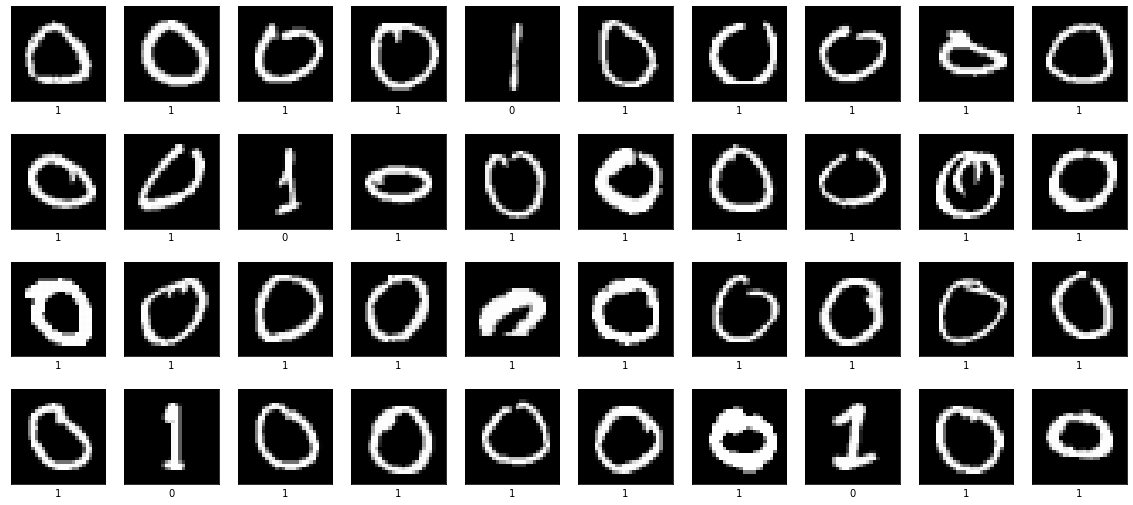

In [39]:
# bad classified samples
rows = 4
cols = 10
plt.figure(figsize=(20,9))
for i in range(0, rows):
    for j in range(0, cols):
        plt.subplot(rows,cols,cols*i+j+1)
        plt.imshow(Xts[bad[cols*i+j]][1:].reshape(28,28), cmap='gray')
        plt.xlabel(int(yhat[bad[cols*i+j]]))
        plt.xticks([])
        plt.yticks([])
plt.show()

In [40]:
np.diff(y).shape

NameError: name 'y' is not defined